# R Aquilae: visualisation
---

In [2]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import torch
import time
import ipywidgets
import k3d

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants
from ipywidgets           import interact

from pomme.utils       import convert_angular_to_spatial
from pomme.plot        import plot_cube_2D, plot_spectrum
from pomme.object      import AstroObject
from pomme.observation import DataCube, Beam

from pomme.model       import TensorModel, SphericallySymmetric
from pomme.utils       import print_var, interpolate, convert_angular_to_spatial
from pomme.lines       import Line
from pomme.loss        import Loss, diff_loss

In [3]:
model = TensorModel.load('tm_R_Aql_model_4.h5')

In [4]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +9.957e+00     +1.409e+01     +2.143e+01
  log_temperature            Free          True     +5.218e+00     +7.313e+00     +9.452e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  velocity_r                 Free          True     -3.237e-01     +1.054e+00     +3.564e+00
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 100)


In [5]:
# print('v_in  =', torch.exp(model['log_v_in' ]).item() / 1.0e+3, 'km/s')
# print('v_inf =', torch.exp(model['log_v_inf']).item() / 1.0e+3, 'km/s')

In [6]:
rho = torch.exp(model['log_CO']).data.numpy().astype(np.float32)

In [7]:
v_r = torch.exp(model['velocity_r']).data.numpy().astype(np.float32)

In [8]:
tmp = torch.exp(model['log_temperature']).data.numpy().astype(np.float32)

In [9]:
r = model.get_radius(origin='centre')

In [13]:
plt_vol_rho = k3d.volume(
    volume      = rho / 1.0e+6,
    alpha_coef  = 25.0,
    # color_range = [199, 200],
    color_map   = k3d.colormaps.matplotlib_color_maps.Magma
)

plt_vol_v_r = k3d.volume(
    volume      = v_r,
    alpha_coef  = 25.0,
    # color_range = [199, 200],
    color_map   = k3d.colormaps.matplotlib_color_maps.Magma
)

plt_vol_tmp = k3d.volume(
    volume      = tmp,
    alpha_coef  = 25.0,
    # color_range = [199, 200],
    color_map   = k3d.colormaps.matplotlib_color_maps.Magma
)

# plt_levels = k3d.marching_cubes(
#     scalar_field = rho / 1.0e+6,
#     level        = 10
# )

plot  = k3d.plot()
plot += plt_vol_rho
plot += plt_vol_v_r
plot += plt_vol_tmp
# plot += plt_levels

plot.display()
plot.grid_visible = False

Output()

In [11]:
for angle in np.linspace(0, 360, 100):
    plot.camera = plot.get_auto_camera(factor=0.7, yaw=angle, pitch=75)
    time.sleep(0.05)

## Movie
---

In [12]:
plot.camera_auto_fit = True
plot.grid_auto_fit   = True

out = ipywidgets.Output()

@plot.yield_screenshots
def animate():
    for angle in np.linspace(0, 360, 100):
        plot.camera = plot.get_auto_camera(factor=0.7, yaw=angle, pitch=75)
        plot.fetch_screenshot()
        screenshot = yield
        file_name  = f'figures/model_1/m3_angle={angle:03.0f}.png'
        with open(file_name, 'wb') as file:
            file.write(screenshot)
        with out:
            print(file_name)
    with out:
        print('Done')

animate()
print('running in background...')
out

running in background...


Output()

In [1]:
!ffmpeg -y -framerate 15 -pattern_type glob -i 'figures/model_1/m3_angle*.png' figures/model_1/m3.mp4

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (conda-forge gcc 10.3.0-16)
  configuration: --prefix=/home/frederikd/.conda/envs/magritte --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1658781931804/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1658781931804/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1658781931804/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1658781931804/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-share

## Plot
---

In [11]:
rs_mini = model.get_radius(origin='centre')
rs_mini /= (1.0 * units.au).si.value
r_in    = rs_mini.min()

/tmp/ipykernel_1187487/1132408986.py:23: RuntimeWarning: divide by zero encountered in true_divide
  dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))


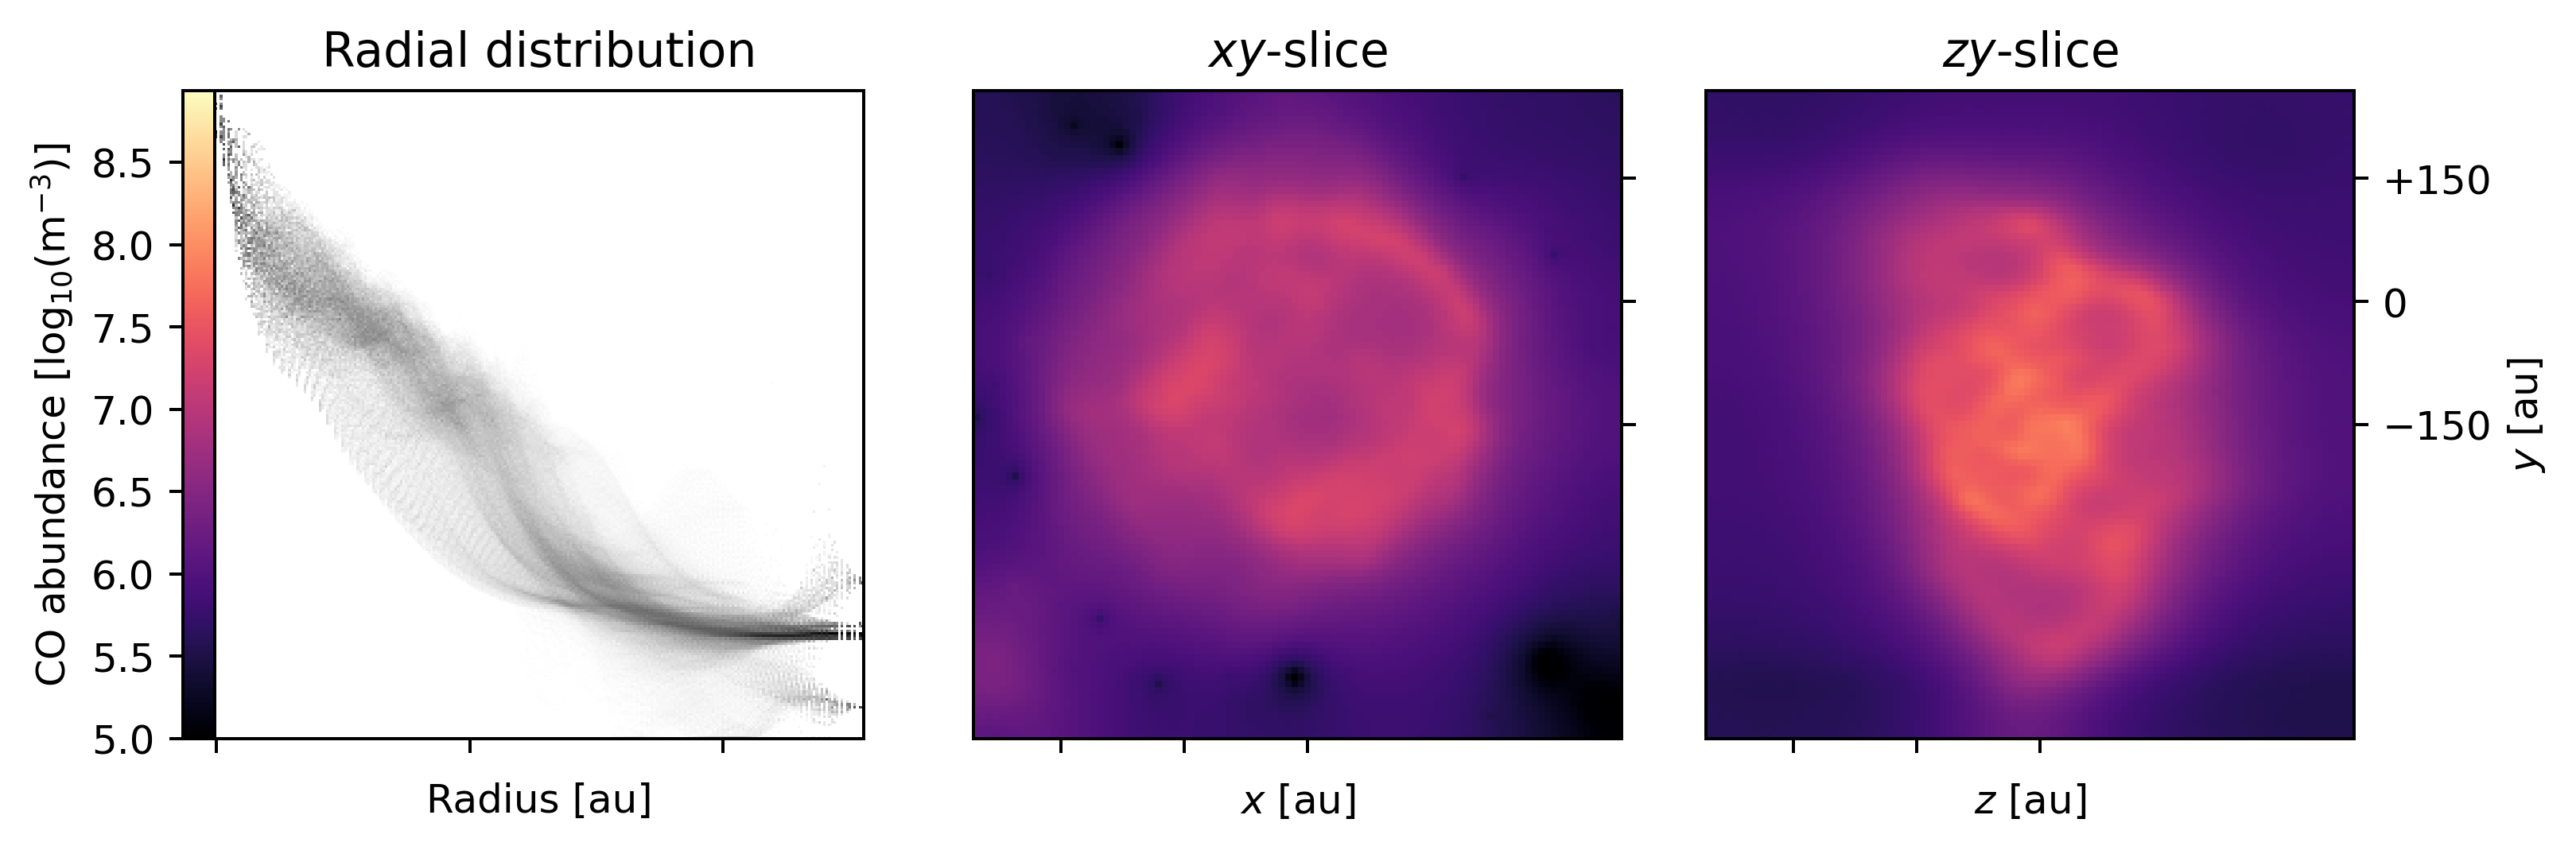

In [21]:
fig, axs = plt.subplots(1,3, dpi=360, figsize=(10.4,3), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

im150  = 13
centre = 32
ip150  = 51

cmap = 'magma' #cubehelix'
cmap2 = 'magma'
alpha = 0.03

axs[0].set_title("Radial distribution")
axs[1].set_title("$xy$-slice")
axs[2].set_title("$zy$-slice")

data2 = (model['log_CO']/np.log(10.0)).data.numpy()

data2[data2<5.0] = 5.0

data2_min = data2.min()
data2_max = data2.max()

dens = np.histogram2d(rs_mini.ravel(), data2.ravel(), bins=(256,256))[0]
dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))
axs[0].imshow(np.flip(np.log(dens+5.0e-3), axis=1).T, cmap='Greys')
# num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
# axs[0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
# axs[0].scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys), s=1, c='tab:blue', alpha=0.005)
pp = axs[1].imshow(data2[:,  :,centre].T, vmin=data2_min, vmax=data2_max, cmap=cmap2)
pp = axs[2].imshow(data2[centre, :, :]  , vmin=data2_min, vmax=data2_max, cmap=cmap2)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].set_xticks([im150, centre, ip150], [])
axs[1].set_yticks([im150, centre, ip150], [])
axs[2].set_xticks([im150, centre, ip150], [])
axs[2].set_yticks([im150, centre, ip150], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0], location='left', pad=0, label='CO abundance [log$_{10}$(m$^{-3})$]')
axs[1].yaxis.tick_right()
axs[2].yaxis.tick_right()
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')


axs[0].set_aspect(1 / axs[0].get_data_ratio())

axs[0].set_xlabel('Radius [au]')
axs[1].set_xlabel('$x$ [au]')
axs[2].set_xlabel('$z$ [au]')
axs[2].set_ylabel('$y$ [au]')

axs[2].yaxis.set_label_position('right')


plt.savefig('m1.png', dpi=360, bbox_inches='tight')

## Scrap Book
---

In [21]:
import healpy

In [29]:
x, y, z = model.get_coords(origin='centre')
ipix    = healpy.pixelfunc.vec2pix(nside=1, x=x, y=y, z=z).ravel()

In [33]:
class Sharp:
        
    def __init__(self, k=0.5):
        
        self.torch_kernel = torch.nn.Conv3d(
            in_channels  = 1,
            out_channels = 1,
            kernel_size  = (3, 3, 3),
            padding      = 'same',
            dtype        = torch.float32
        )

        kernel        = 1.0 / (1-k) * (-k*np.ones((3, 3, 3))/26.0)
        kernel[1,1,1] = 1.0 / (1-k)

        self.torch_kernel.weight.data[0,0] = torch.from_numpy(kernel)
        self.torch_kernel.bias  .data      = torch.zeros_like(torch_kernel.bias)

        self.torch_kernel.weight.requires_grad_(False)
        self.torch_kernel.bias  .requires_grad_(False)

    def apply(self, data):
        """
        Apply torch kernel.
        Assumes the last axis to contain the frequencies / channels.
        """
        dat = data.view(1, 1, data.shape[0], data.shape[1], data.shape[2])
        dat = self.torch_kernel(dat)
        dat = dat.view(data.shape[0], data.shape[1], data.shape[2])
        return dat

In [34]:
sharp = Sharp(k=0.2)

NameError: name 'torch_kernel' is not defined

In [ ]:
dat = np.log(torch.from_numpy(rho))

In [ ]:
dat = sharp.apply(dat)
dat = sharp.apply(dat)
dat = sharp.apply(dat)
dat = sharp.apply(dat)
dat = sharp.apply(dat)
dat = sharp.apply(dat)

In [ ]:
plot_cube_2D(dat)

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
        torch_kernel = torch.nn.Conv3d(
            in_channels  = 1,
            out_channels = 1,
            kernel_size  = (3, 3, 3),
            padding      = 'same',
            dtype        = torch.float64
        )

In [ ]:
torch_kernel.weight.data.shape

torch.Size([1, 1, 3, 3, 3])

In [ ]:


kernel

array([[[-0.00961538, -0.00961538, -0.00961538],
        [-0.00961538, -0.00961538, -0.00961538],
        [-0.00961538, -0.00961538, -0.00961538]],

       [[-0.00961538, -0.00961538, -0.00961538],
        [-0.00961538,  1.25      , -0.00961538],
        [-0.00961538, -0.00961538, -0.00961538]],

       [[-0.00961538, -0.00961538, -0.00961538],
        [-0.00961538, -0.00961538, -0.00961538],
        [-0.00961538, -0.00961538, -0.00961538]]])

In [ ]:
dat = torch.log(torch.from_numpy(rho))

def grav(dat, k=0.2):

    res = dat.clone()

    diff = torch.diff(dat, dim=0)
    res[+1:,:,:][diff>=0] += k*dat[:-1,:,:][diff>=0]
    res[:-1,:,:][diff<=0] += k*dat[+1:,:,:][diff<=0]
    diff = torch.diff(dat, dim=1)
    res[:,+1:,:][diff>=0] += k*dat[:,:-1,:][diff>=0]
    res[:,:-1,:][diff<=0] += k*dat[:,+1:,:][diff<=0]
    diff = torch.diff(dat, dim=2)
    res[:,:,+1:][diff>=0] += k*dat[:,:,:-1][diff>=0]
    res[:,:,:-1][diff<=0] += k*dat[:,:,+1:][diff<=0]

    return res

In [ ]:
plot_cube_2D(dat)

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
dat = grav(dat)

plot_cube_2D(dat)

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
dat

tensor([[[12.9934, 12.9888, 12.9868,  ..., 13.0932, 13.0880, 13.0902],
         [12.9918, 12.9922, 12.9907,  ..., 13.0955, 13.0986, 13.1068],
         [13.0017, 12.9958, 12.9912,  ..., 13.0877, 13.1030, 13.1008],
         ...,
         [12.9702, 12.9687, 12.9750,  ..., 12.9571, 12.9667, 12.9664],
         [12.9646, 12.9670, 12.9588,  ..., 12.9587, 12.9524, 12.9515],
         [12.9603, 12.9666, 12.9562,  ..., 12.9608, 12.9558, 12.9577]],

        [[12.9985, 12.9887, 12.9860,  ..., 13.0913, 13.0928, 13.1077],
         [13.0038, 12.9957, 12.9891,  ..., 13.0972, 13.0918, 13.1045],
         [13.0127, 13.0033, 12.9959,  ..., 13.0970, 13.0968, 13.1035],
         ...,
         [12.9612, 12.9613, 12.9697,  ..., 12.9523, 12.9621, 12.9558],
         [12.9613, 12.9631, 12.9632,  ..., 12.9577, 12.9428, 12.9474],
         [12.9608, 12.9714, 12.9615,  ..., 12.9445, 12.9526, 12.9509]],

        [[13.0048, 12.9960, 12.9978,  ..., 13.0840, 13.0949, 13.1011],
         [13.0081, 13.0061, 12.9945,  ..., 13

In [ ]:
dat

tensor([[[38.9741, 38.9643, 38.9534,  ..., 39.2725, 13.0880, 26.1782],
         [12.9918, 51.9636, 51.9472,  ..., 52.3600, 52.3739, 65.5008],
         [51.9892, 51.9738, 38.9561,  ..., 13.0877, 78.5895, 13.1008],
         ...,
         [51.8646, 38.8971, 64.8441,  ..., 25.9094, 77.7645, 51.8396],
         [38.8862, 64.8202, 25.9150,  ..., 64.7809, 38.8466, 25.8988],
         [12.9603, 38.8831, 12.9562,  ..., 64.7790, 38.8608, 51.8159]],

        [[38.9806, 25.9747, 25.9651,  ..., 26.1753, 52.3639, 65.4962],
         [51.9898, 51.9657, 38.9597,  ..., 78.5648, 13.0918, 52.3987],
         [78.0289, 51.9907, 77.9533,  ..., 39.2814, 26.1885, 52.4011],
         ...,
         [12.9612, 25.9225, 51.8635,  ..., 12.9523, 51.8129, 25.9031],
         [38.8833, 38.8857, 51.8466,  ..., 77.6973, 12.9428, 38.8365],
         [38.8778, 64.8235, 38.8766,  ..., 25.8820, 64.7288, 38.8418]],

        [[38.9993, 25.9847, 64.9613,  ..., 13.0840, 39.2716, 39.2949],
         [65.0239, 64.9963, 51.9682,  ..., 65

In [ ]:
np.diff([1,2,3])

array([1, 1])

In [ ]:
a = np.array([1,2,3])

In [ ]:
a[:-1]

array([1, 2])